This is a revised version of my final project for 'Machine Learning and Advanced Analytics for Biomedicine'.
Data/Project Descriptions came from http://medicaldecathlon.com/. Data is available under BRATS (Brain Tumor) data.

Much inspiration was taken from MONAI documentation (https://docs.monai.io/en/stable/) and the accompanying the MONAI tutorials which I followed/modified (https://github.com/Project-MONAI). It was really a focus for me to break down and understand any code elements that I repurposed, and do the model design/parameter in a way that was different from tutorials based on my own research so I could explore/do something original and see what happened. 


In [1]:
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism

import torch

In [2]:
##for reproducibility
set_determinism(seed=0)

#env issue
os.environ['KMP_DUPLICATE_LIB_OK']='True'



In [3]:
##generate new transform to define labels
##from MONAI tutorials, additional transforms taken from MONAI documentation https://monai.io/docs.html
class BratsToMultiChannel(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(torch.logical_or(torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1))
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = torch.stack(result, axis=0).float()
        return d



In [4]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        BratsToMultiChannel(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)
'''ABOVE in the section labeled image modifications we have a technique taken from the MONAI tutorials: random crop, 
    flip, and light/contour intensity change in training of each image is used for better training.
        
    Rather than cropping all images to the same size (a technique which I also considered), the MONAI
    technique prefers to train on smaller portions of each image for efficiency
    
    Downside of this approach: every image takes longer to train (this time really adds up!)
'''

val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        BratsToMultiChannel(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)


In [5]:
# here we don't cache any data bc of out of memory issue
root_dir = "C:/Sahana/BrainTumorSegmentationProject/Task01_BrainTumour/"
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=train_transform,
    section="training",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0)

# load validation dataset
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0)

print(len(train_loader))
print(len(val_loader))

388
96


image shape: torch.Size([4, 240, 240, 155])


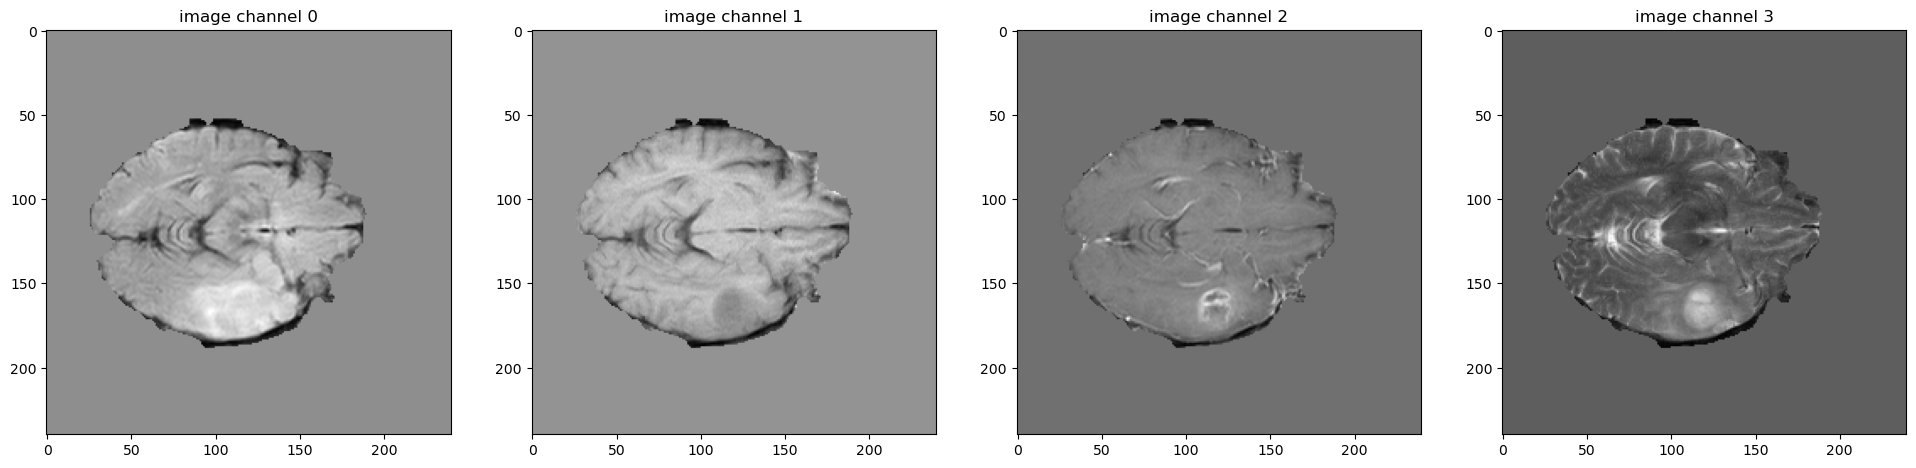

label shape: torch.Size([3, 240, 240, 155])


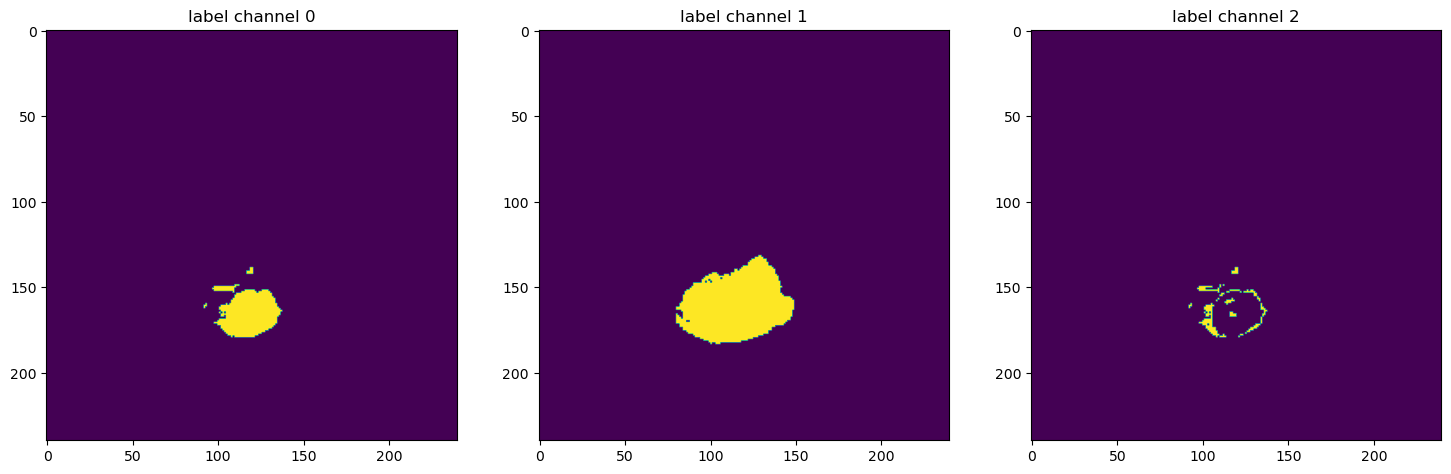

In [6]:
# pick one image from DecathlonDataset to visualize and check the 4 channels
val_data_example = val_ds[2]

print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, :, 60].detach().cpu(), cmap="gray")
plt.show()

# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val_data_example["label"][i, :, :, 60].detach().cpu())
plt.show()


I had some debate over whether to use a U-NET or SegNet model. According to the source below, "The results show the superior ability of SegNet in classifying infected/non-infected tissues compared to the other methods (with 0.95 mean accuracy), while the U-NET shows better results as a multi-class segmentor (with 0.91 mean accuracy)"

source: https://bmcmedimaging.biomedcentral.com/articles/10.1186/s12880-020-00529-5

In this case, as the BRATS dataset has multiple classes (tumor core, enhancing, edema), I will use a U-NET. 

In [7]:
##creating model, loss, and optimizer
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss, DiceCELoss

import torch


max_epochs = 10
val_interval = 1
VAL_AMP = True


device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=4,
    out_channels=3,
    channels=(16, 32, 64, 128, 256), 
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
)#.to(device)


##loss function, optimizer
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose(
    [Activations(sigmoid=True), AsDiscrete(threshold=0.5)]
)


# define inference method
def inference(input):

    def _compute(input):
        #print(input.shape)
        #NOTE: forgot to comment this out but at that point the code had been running for a few hours and I didn't want to rerun just to remove this
        print()
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler() 

c:\Users\sahan\anaconda3\lib\site-packages\torch\cuda\amp\grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


In [8]:
##train model
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"],#.to(device),
            batch_data["label"],#.to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():

            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"],#.to(device),
                    val_data["label"],#.to(device),
                )
                if val_inputs.shape != (1, 4, 240, 240, 155):
                    continue

                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start


----------
epoch 1/10


c:\Users\sahan\anaconda3\lib\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1/388, train_loss: 0.9519, step time: 6.0231
2/388, train_loss: 0.9673, step time: 5.1303
3/388, train_loss: 0.9785, step time: 4.7179
4/388, train_loss: 0.9875, step time: 4.8631
5/388, train_loss: 0.9922, step time: 4.8641
6/388, train_loss: 0.9620, step time: 5.1117
7/388, train_loss: 0.9738, step time: 4.9405
8/388, train_loss: 0.9570, step time: 4.4989
9/388, train_loss: 0.9531, step time: 4.9331
10/388, train_loss: 0.9059, step time: 4.6246
11/388, train_loss: 0.9337, step time: 4.7982
12/388, train_loss: 0.9932, step time: 5.0375
13/388, train_loss: 0.9318, step time: 4.7062
14/388, train_loss: 0.9844, step time: 4.6395
15/388, train_loss: 0.9860, step time: 4.5775
16/388, train_loss: 0.9227, step time: 4.7480
17/388, train_loss: 0.9574, step time: 4.7031
18/388, train_loss: 0.9486, step time: 4.6910
19/388, train_loss: 0.9782, step time: 4.6406
20/388, train_loss: 0.9901, step time: 4.6092
21/388, train_loss: 0.9858, step time: 4.6375
22/388, train_loss: 0.9893, step time: 4.74

Below is some other code I was examining: showed that there were some datapoints with only one channel of image available. How to deal with these? I would think on this further in the future. 

In [10]:
# for val_data in val_loader:
#     val_inputs, val_labels = (
#         val_data["image"],#.to(device),
#         val_data["label"],#.to(device),
#     )
#     ##any abnormal images (dataset was defined such that shape should not vary, but in case)
#     if val_inputs.shape != (1, 4, 240, 240, 155):
#         print(val_inputs.shape)
#         test_im_show = val_inputs

In [11]:
print(f"train completed, best_metric: {best_metric:.4f} total time: {total_time}.")

train completed, best_metric: 0.5874 total time: 194055.81723737717.


A huge part of this (an issue I didn't consider when starting this project), is that the metric (even within training) is so low. This most likely occurs due to limited computational capacity, and therefore only being able to run for a short number of epochs (10 as opposed to 100+, which would be desirable)
Still, let us visualize one image + the model's predictions:

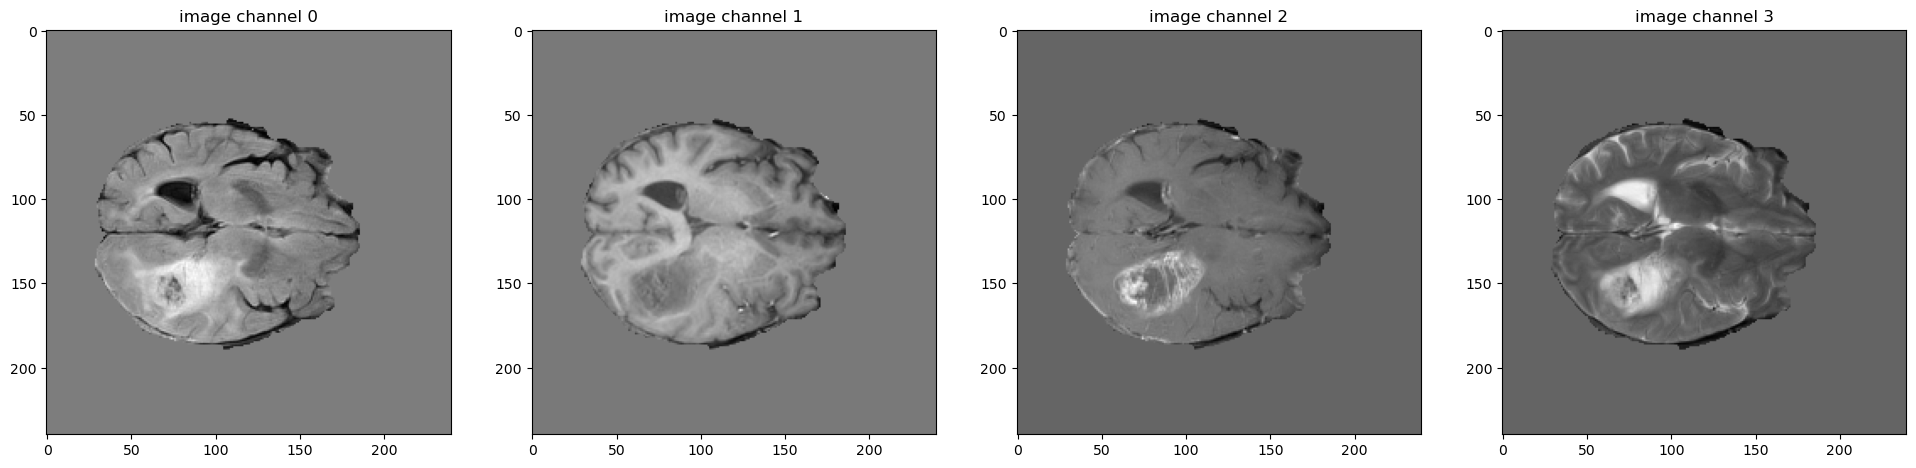

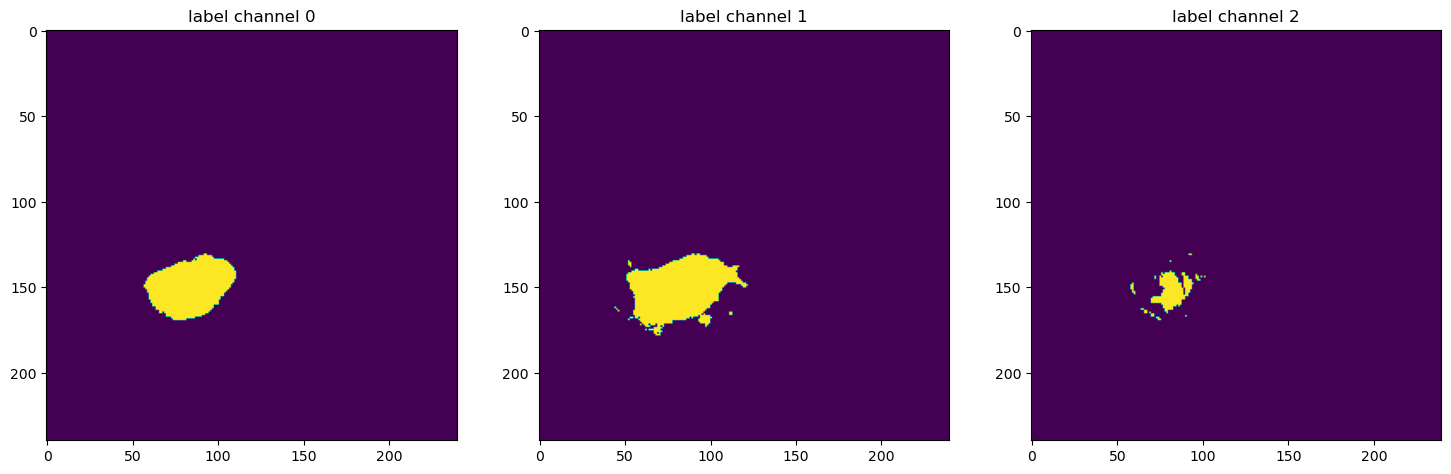

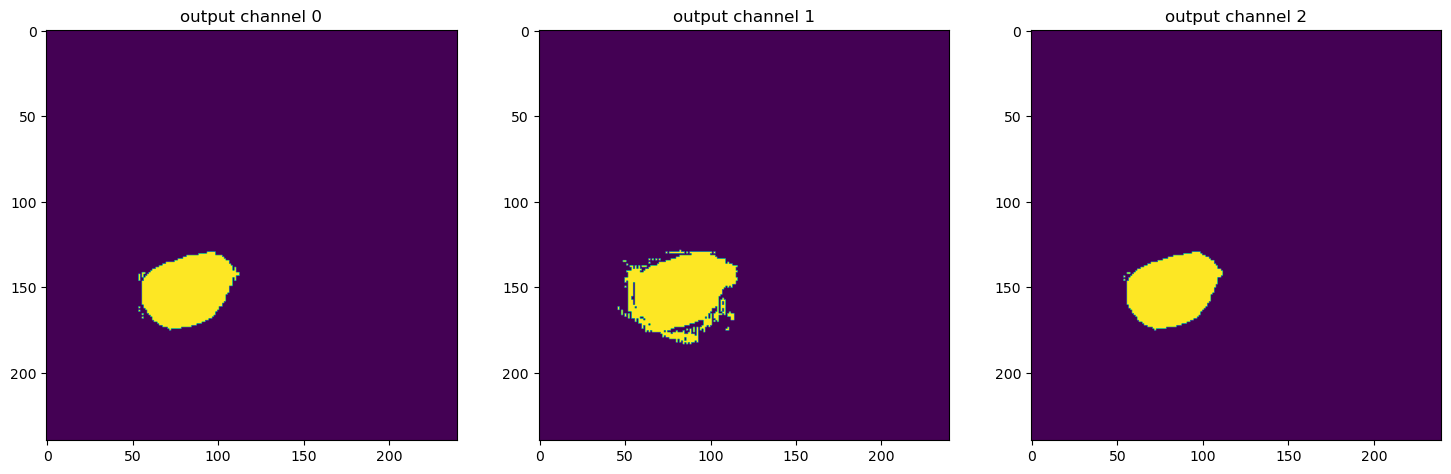

In [12]:
val_input = val_ds[6]["image"].unsqueeze(0)
roi_size = (128, 128, 64)
sw_batch_size = 4
val_output = inference(val_input)
val_output = post_trans(val_output[0])
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_ds[6]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
plt.show()
    
# visualize the 3 labels
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val_ds[6]["label"][i, :, :, 70].detach().cpu())
plt.show()
    
# visualize the 3 channels model output corresponding to this image
plt.figure("output", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"output channel {i}")
    plt.imshow(val_output[i, :, :, 70].detach().cpu())
plt.show()

As we can see, the model is not able to fully focus and capture the exact area with the tumor localization. Furthermore, it has predicted very similarly for all three channels. Below, let us visualize 10 images from the dataset, the model's prediction, and the actual labels for a qualitative comparison.

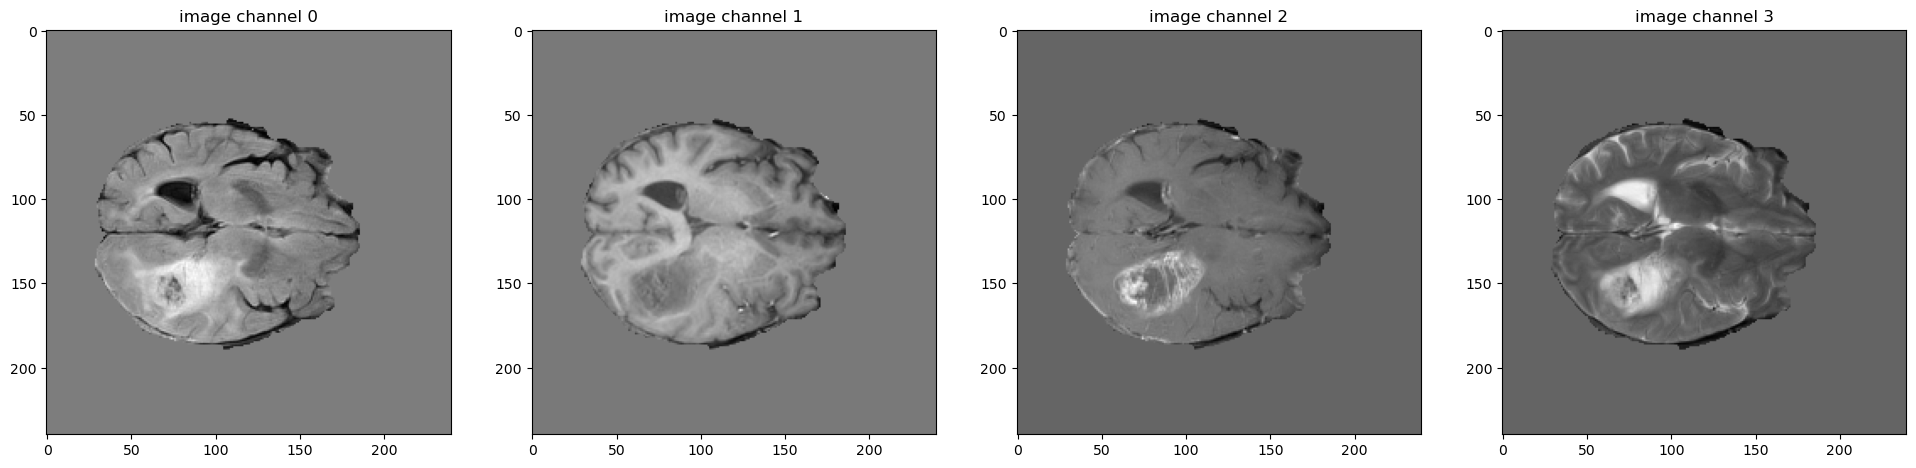

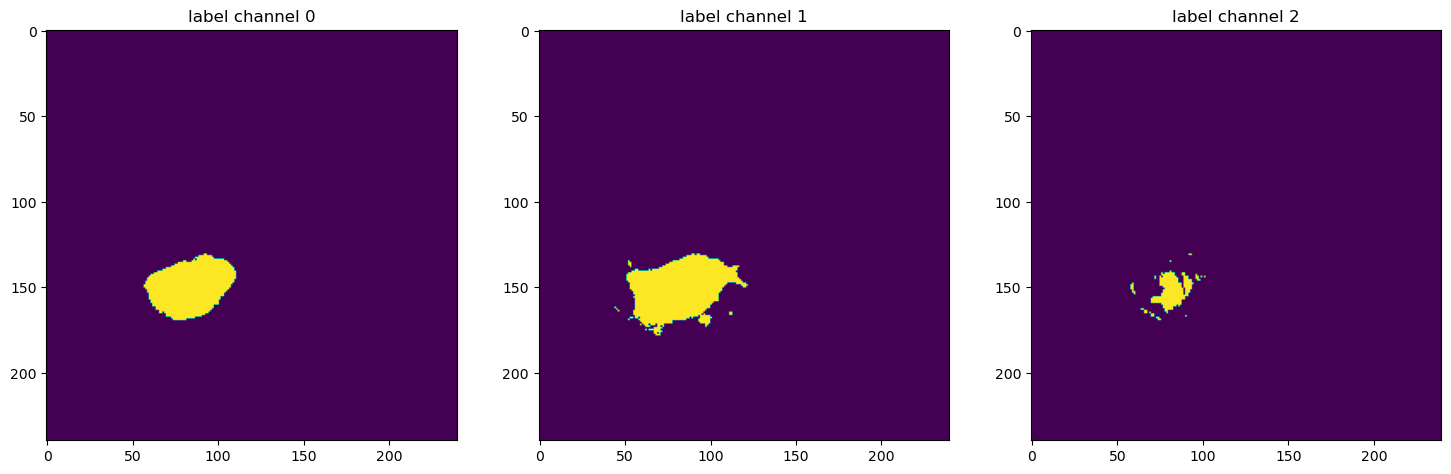

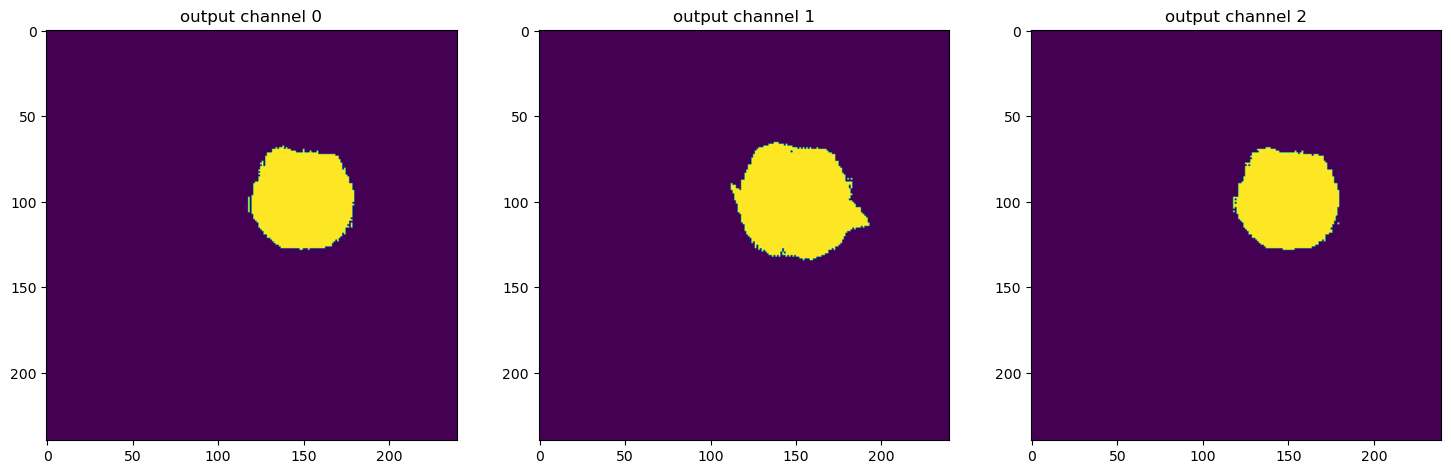

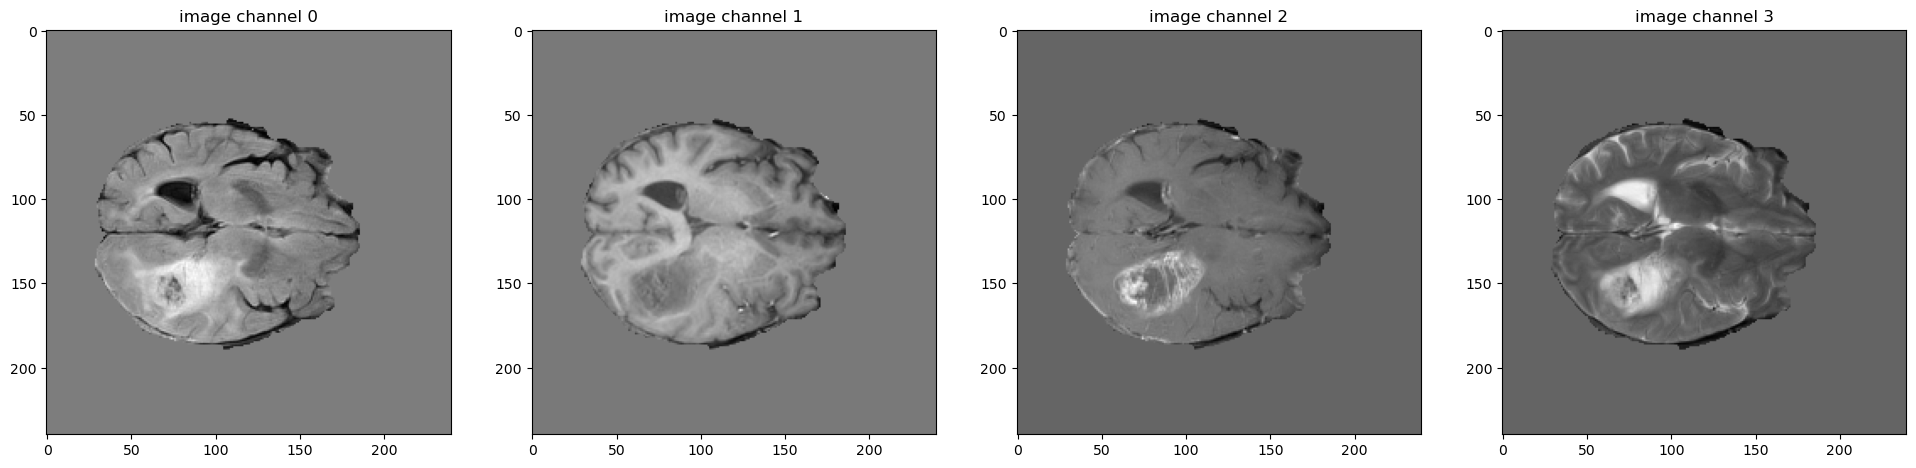

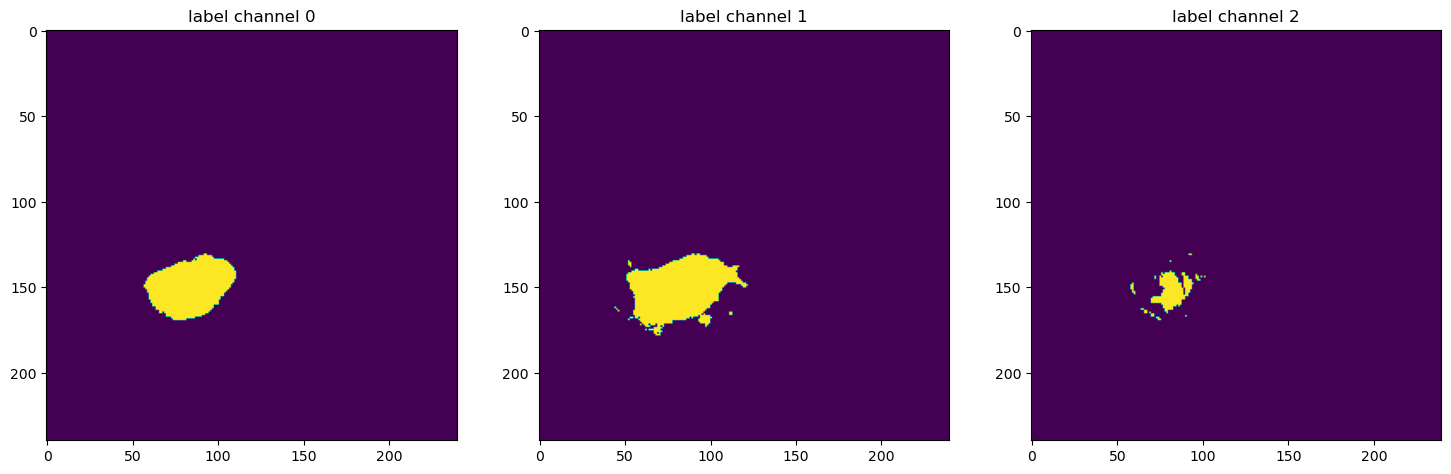

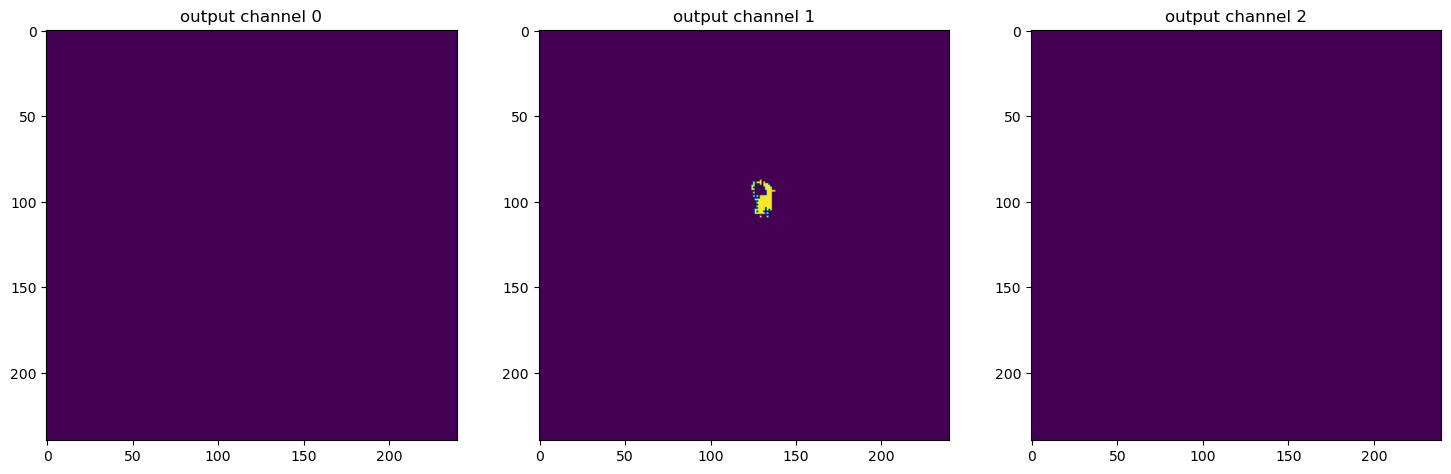

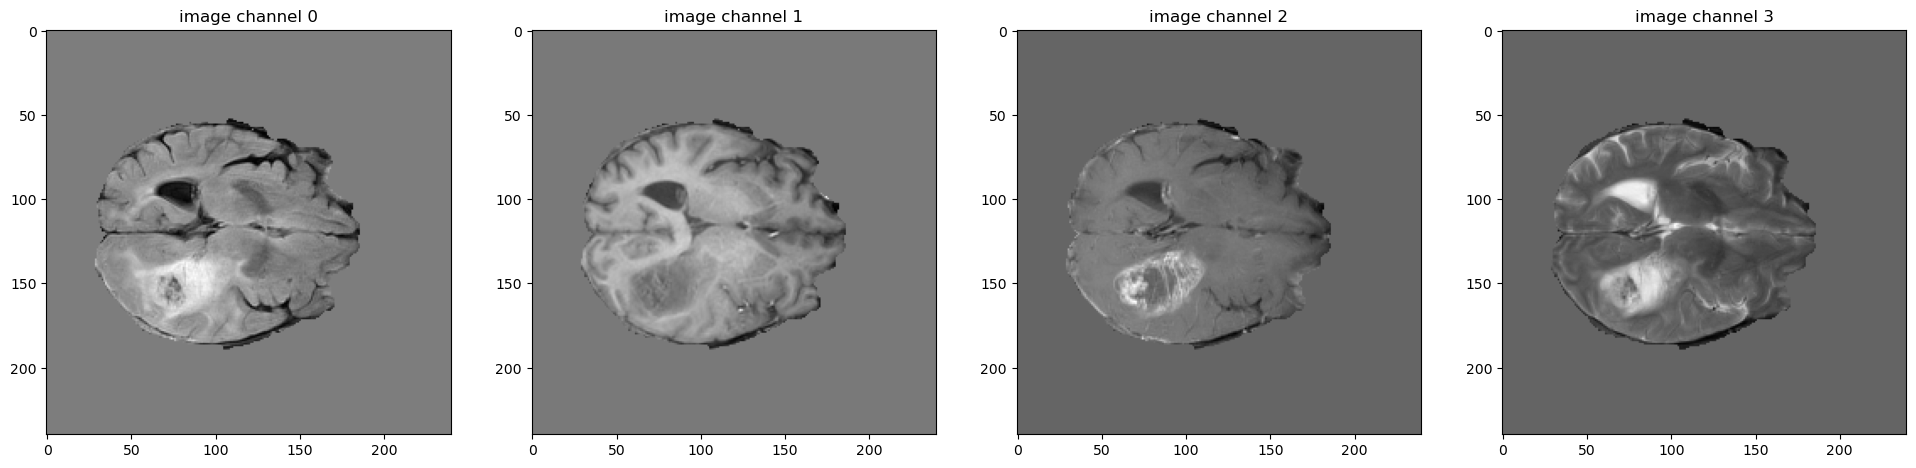

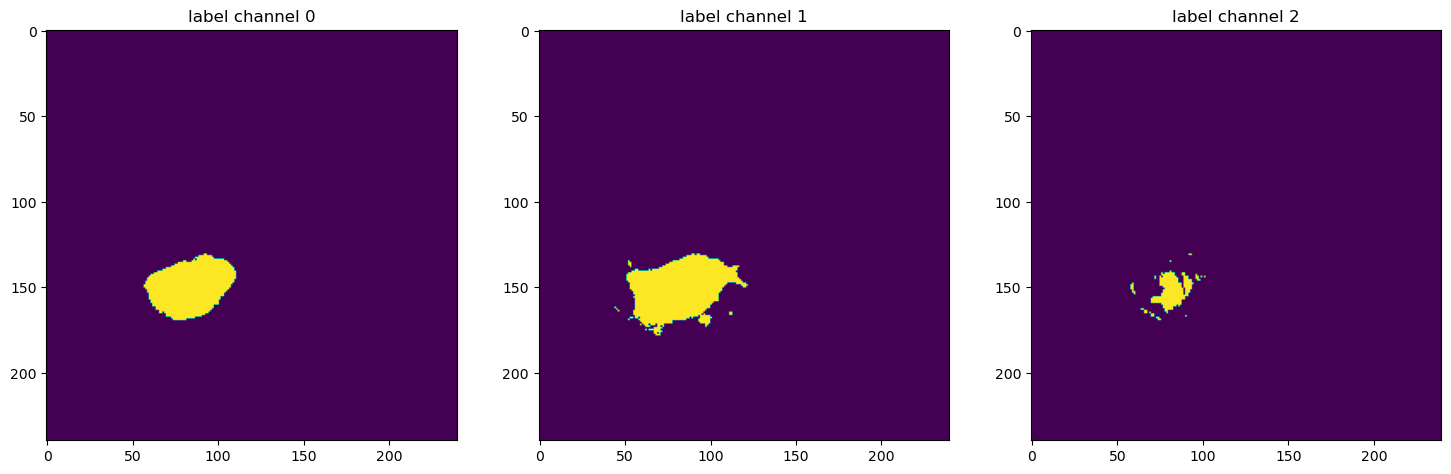

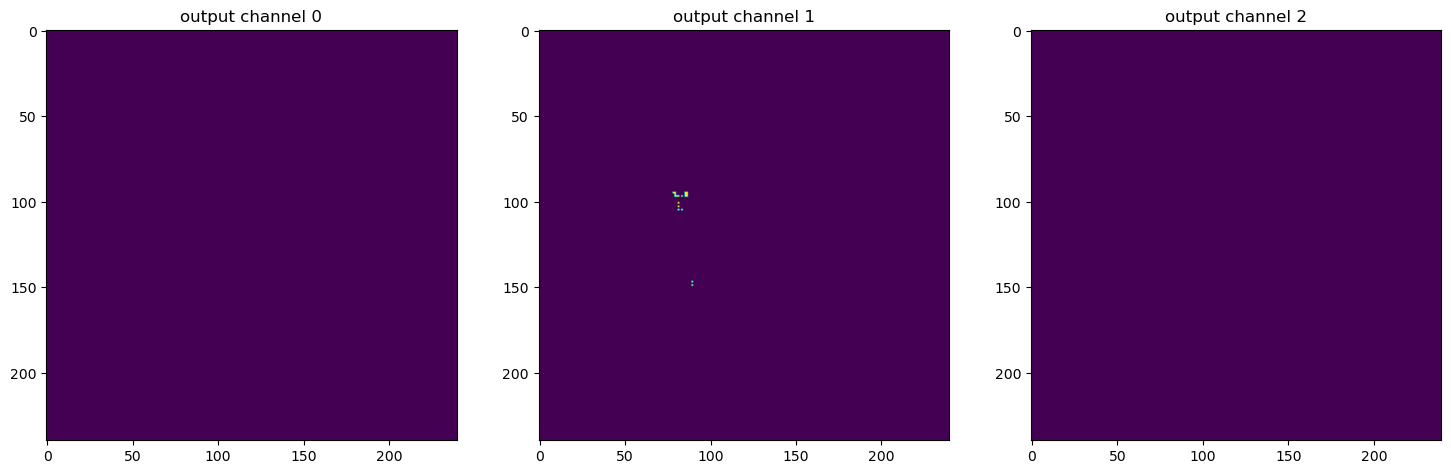

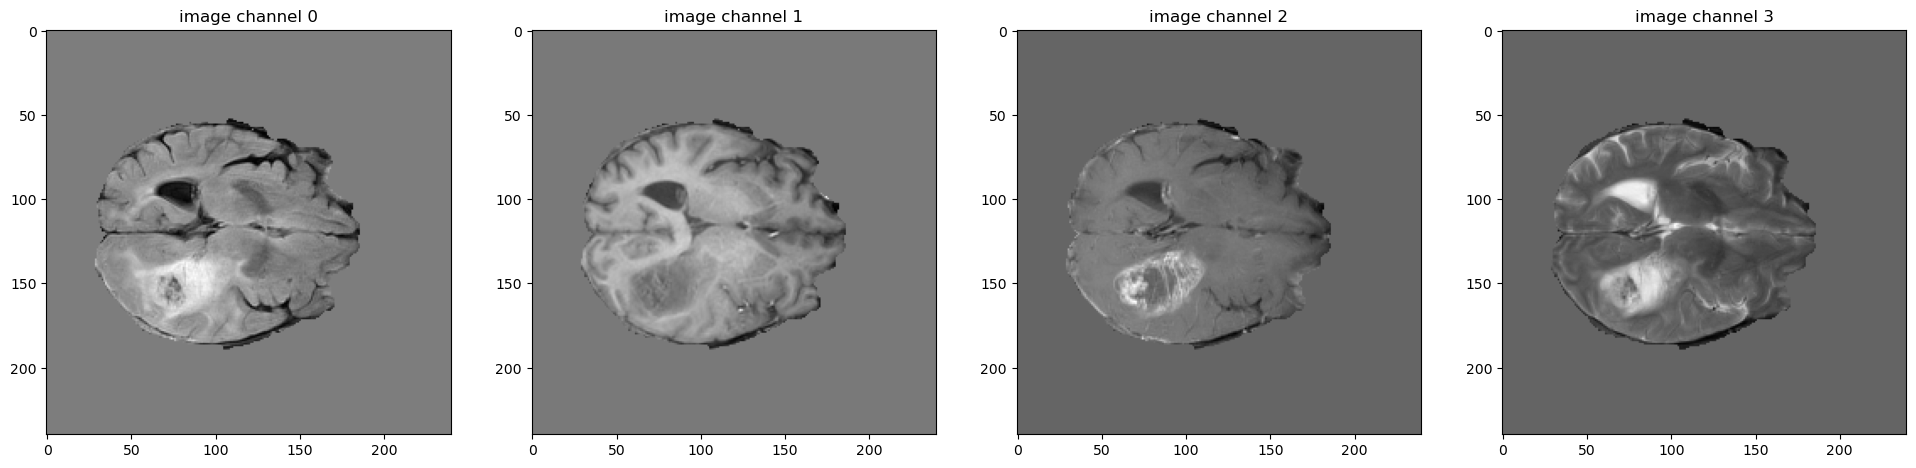

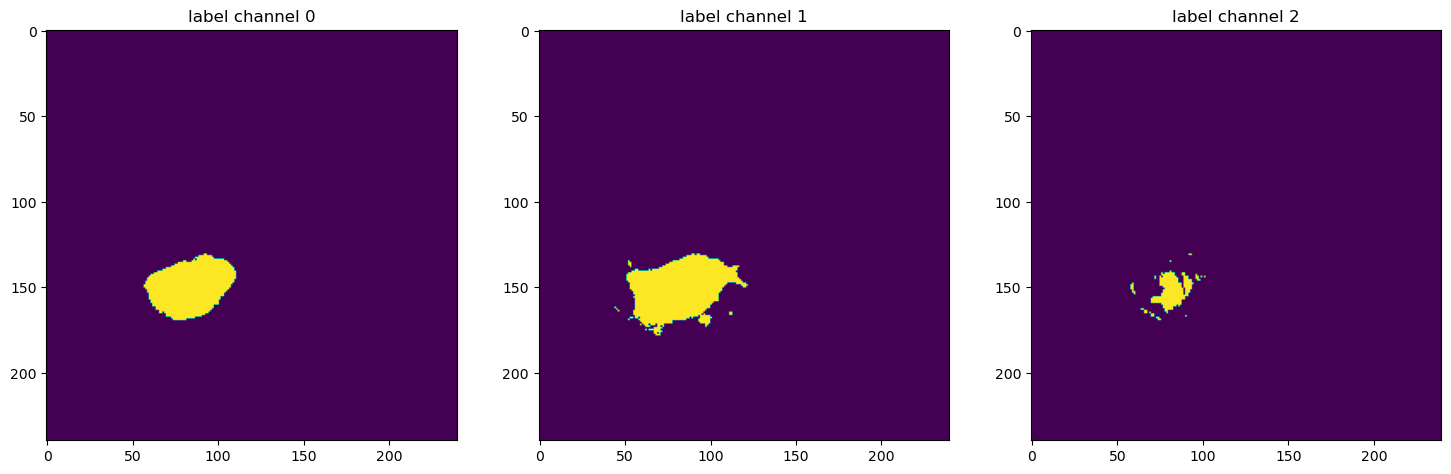

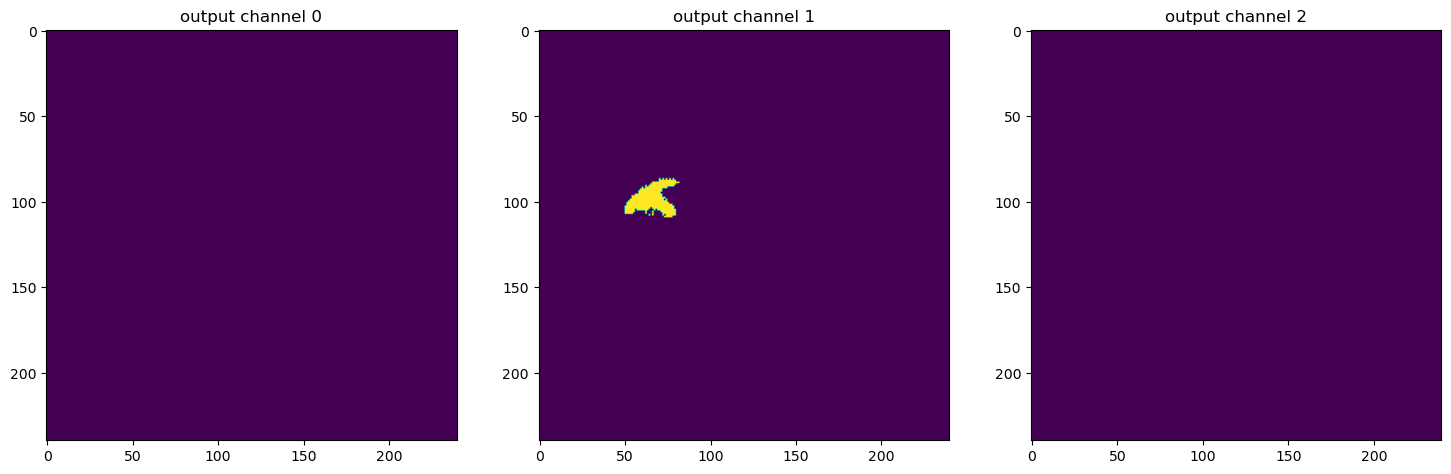

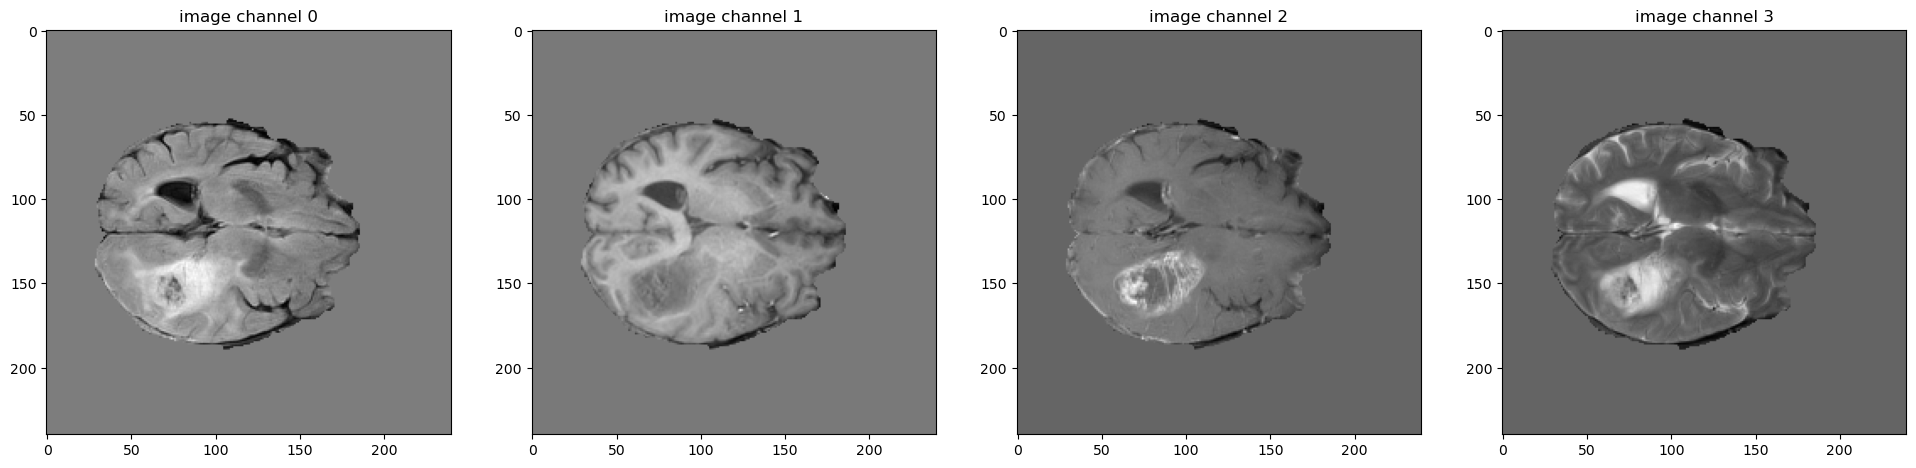

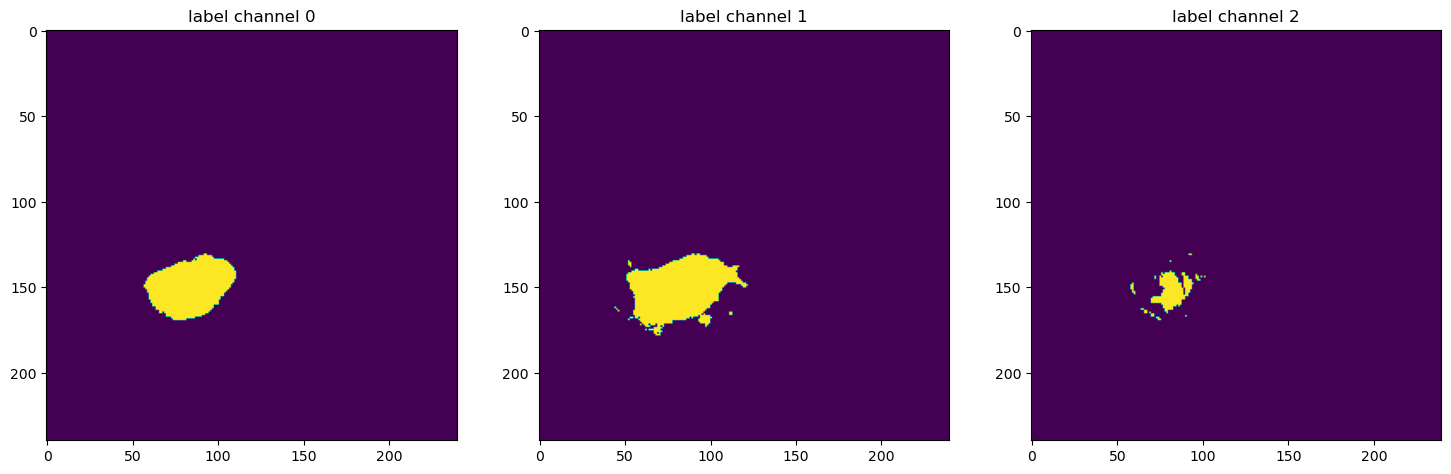

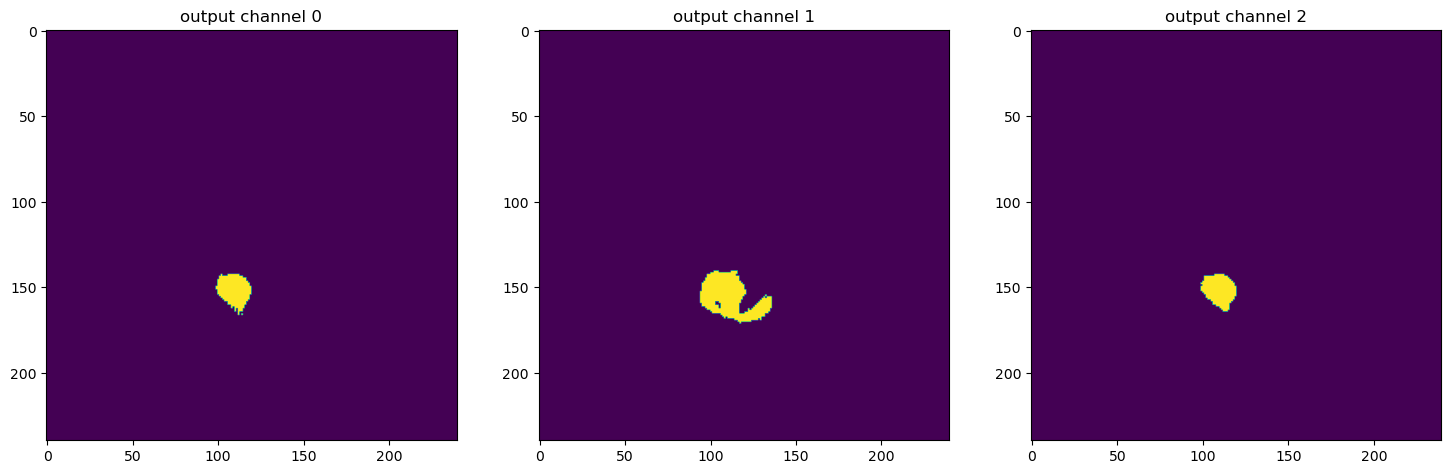

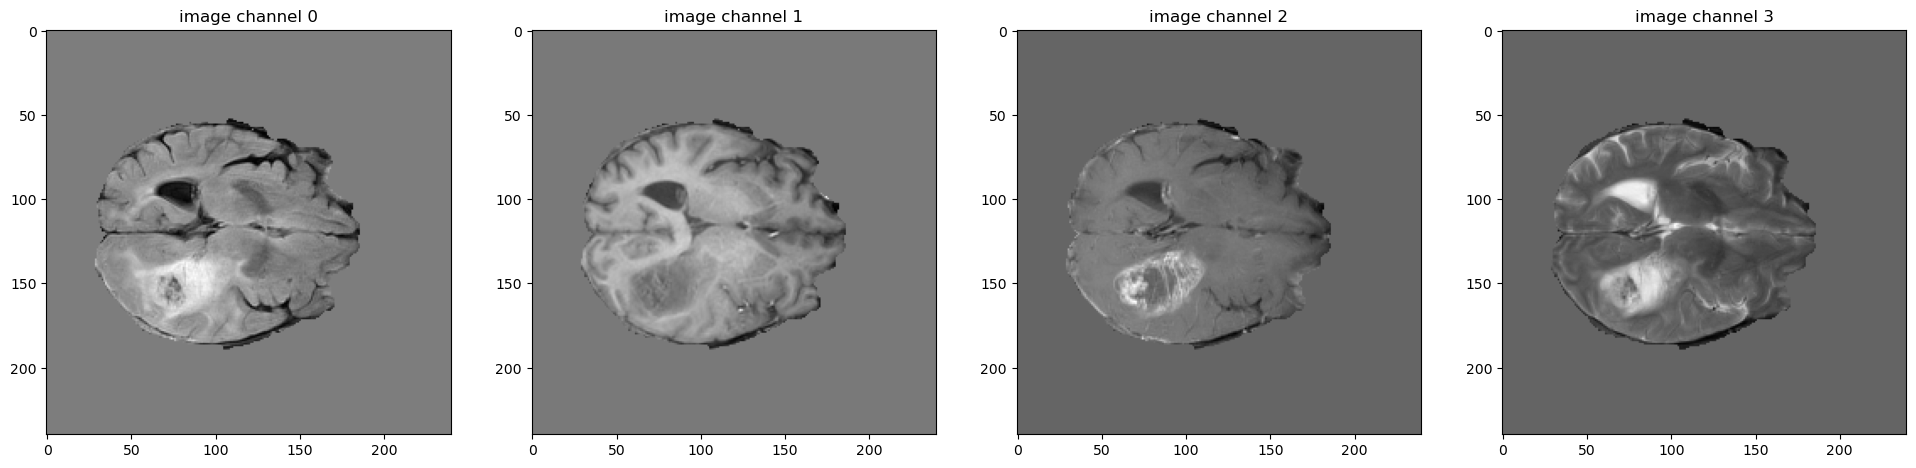

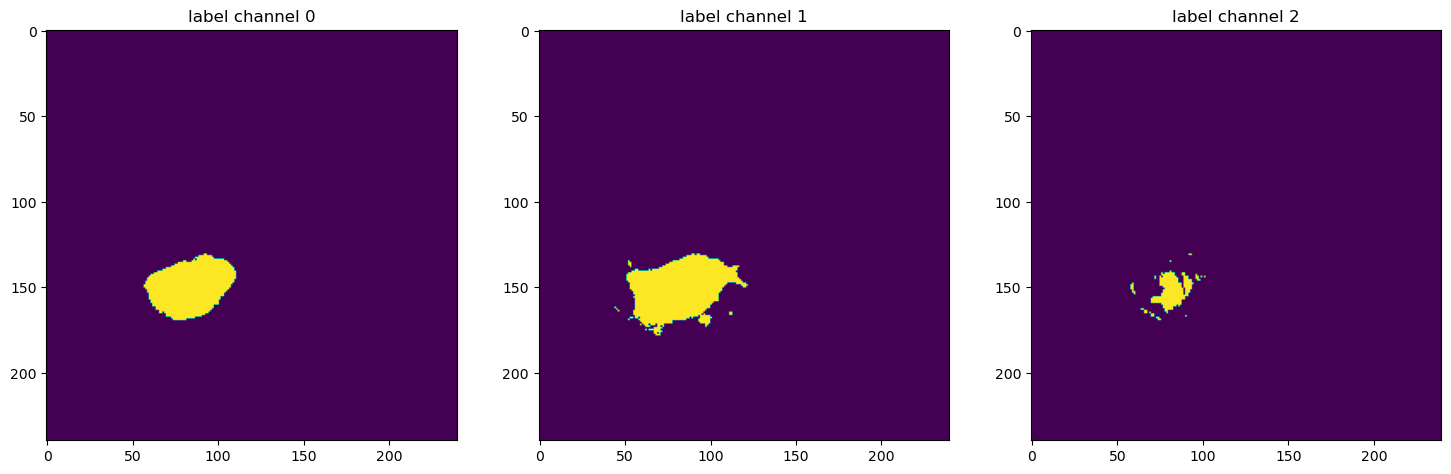

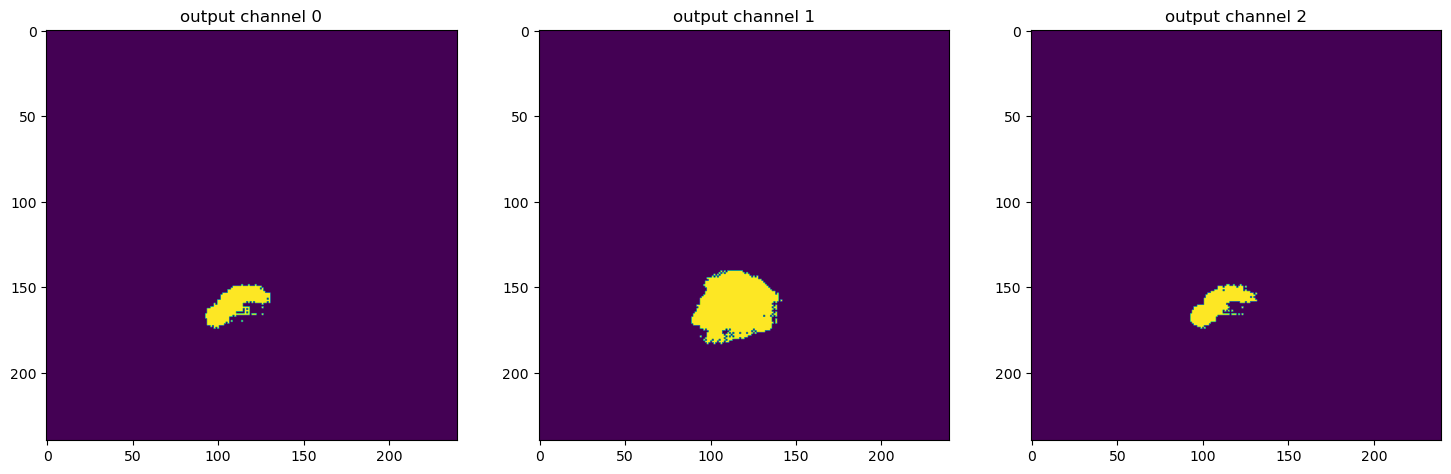

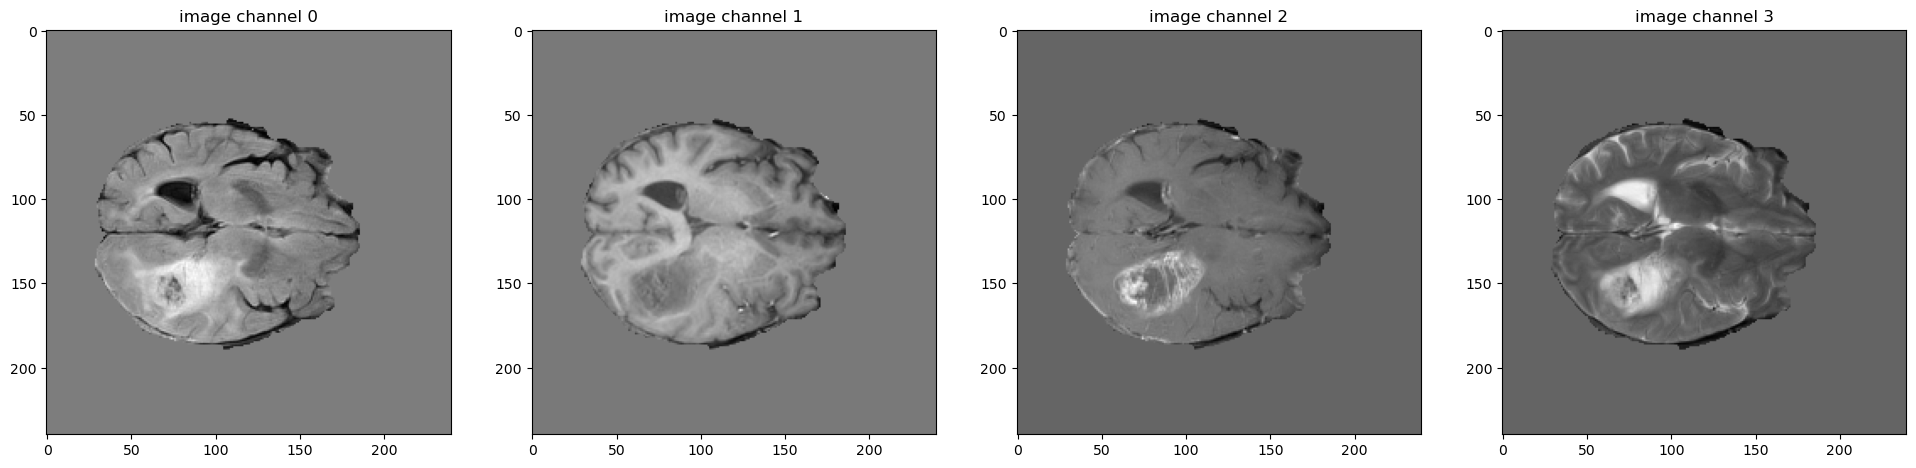

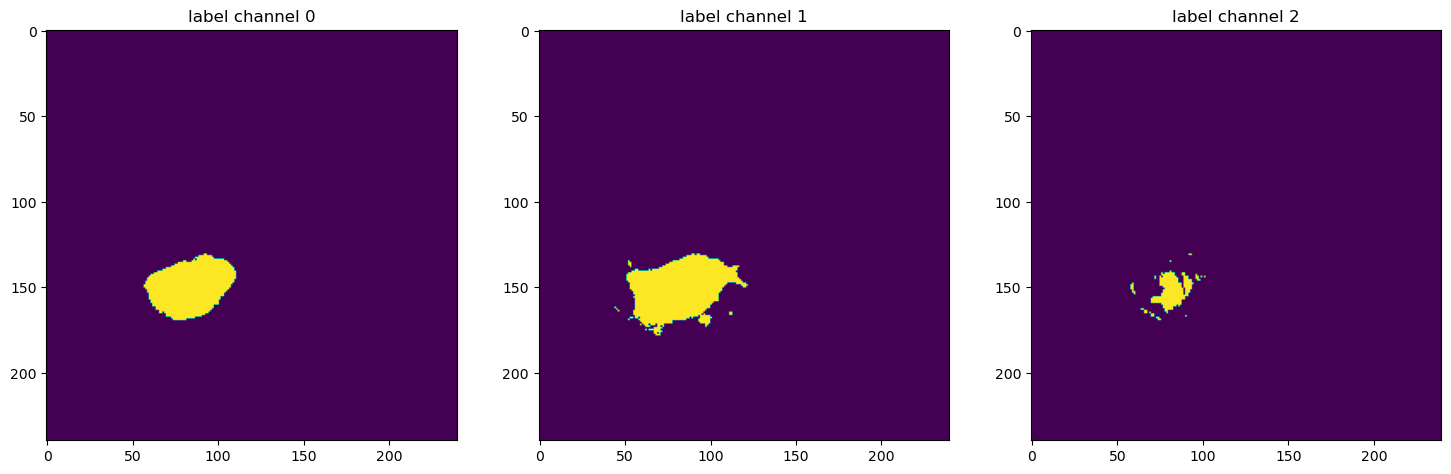

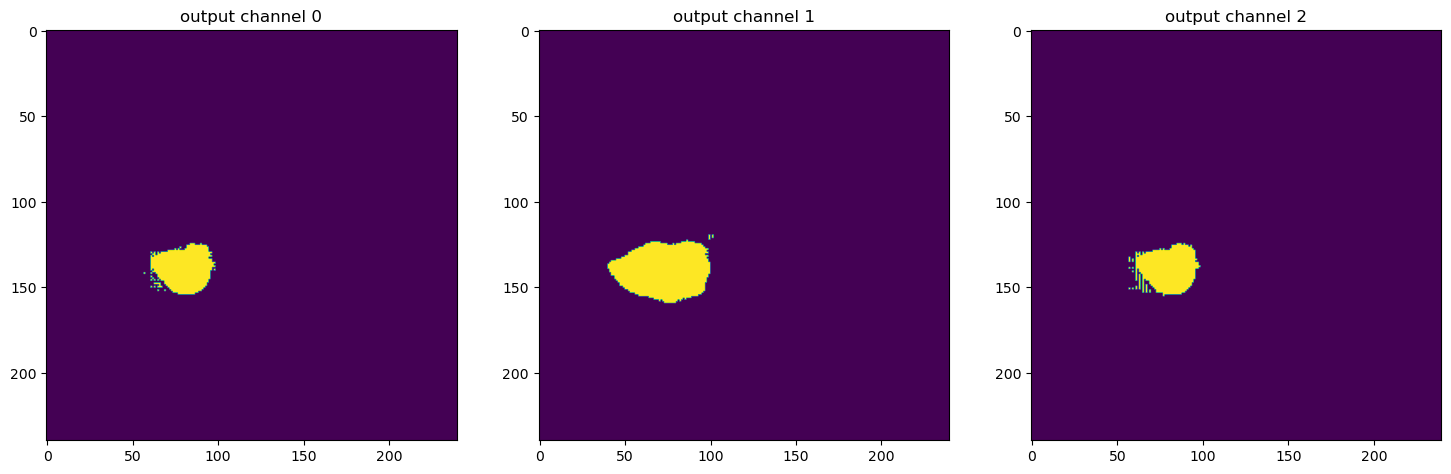

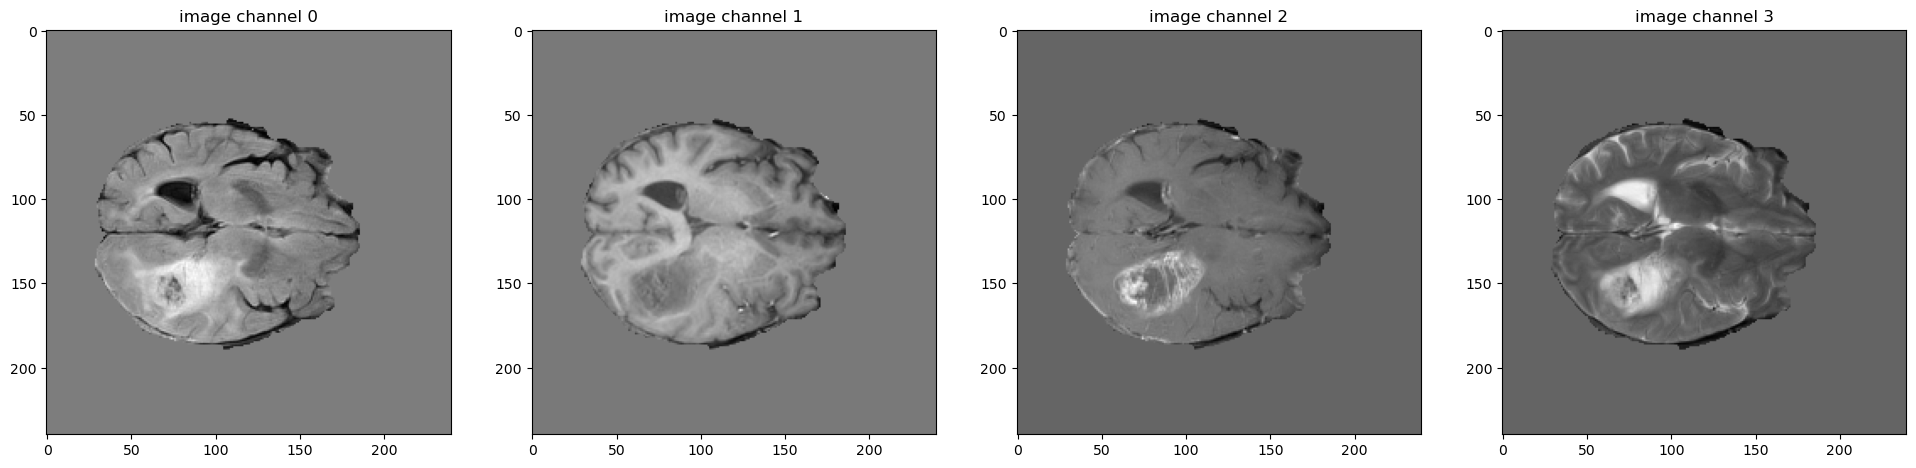

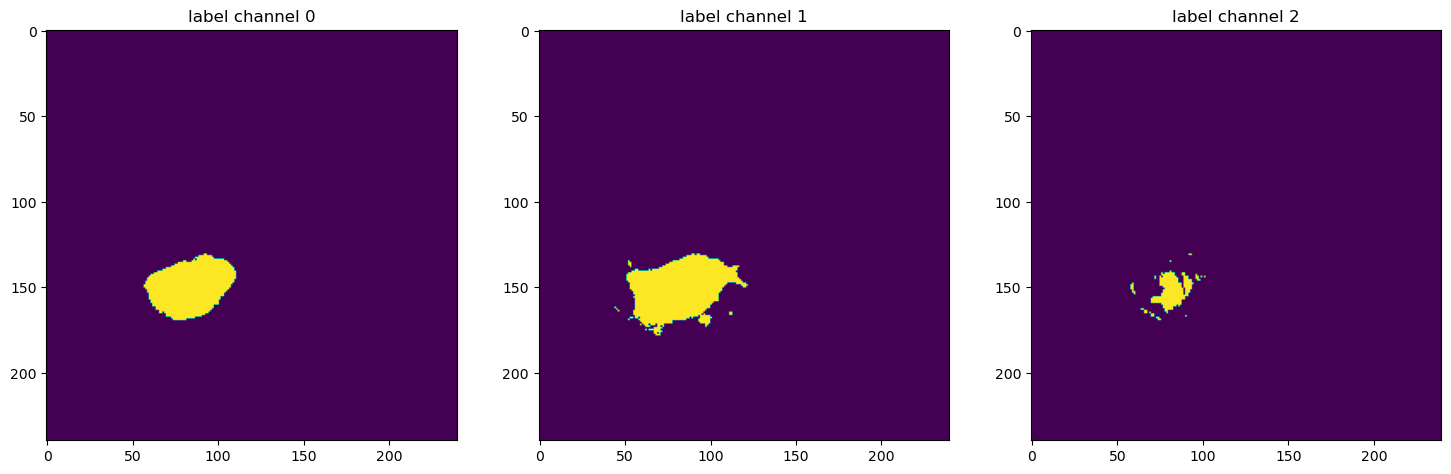

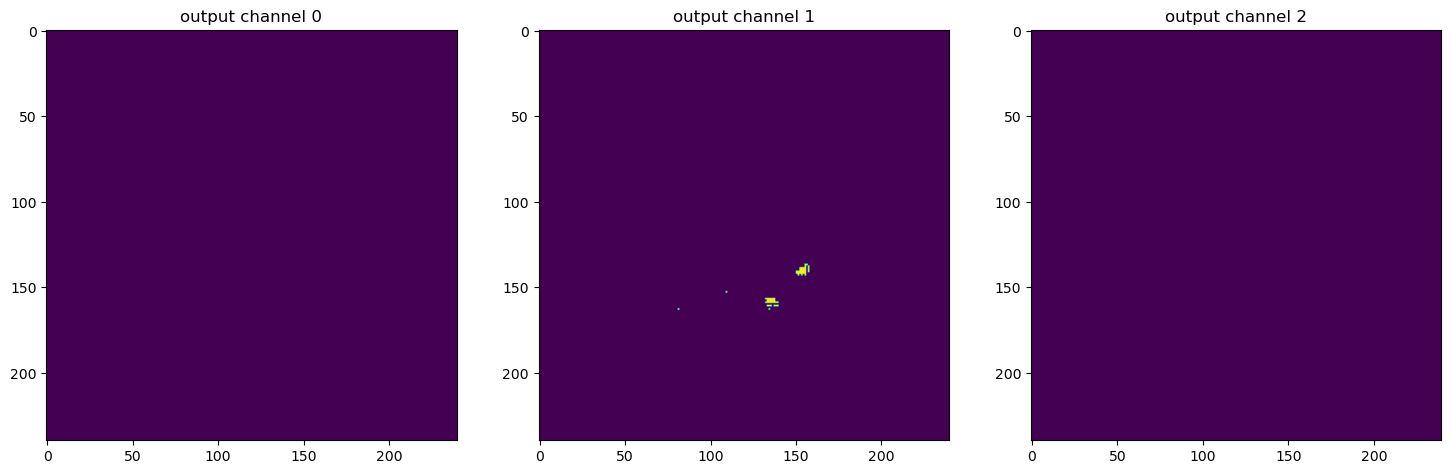

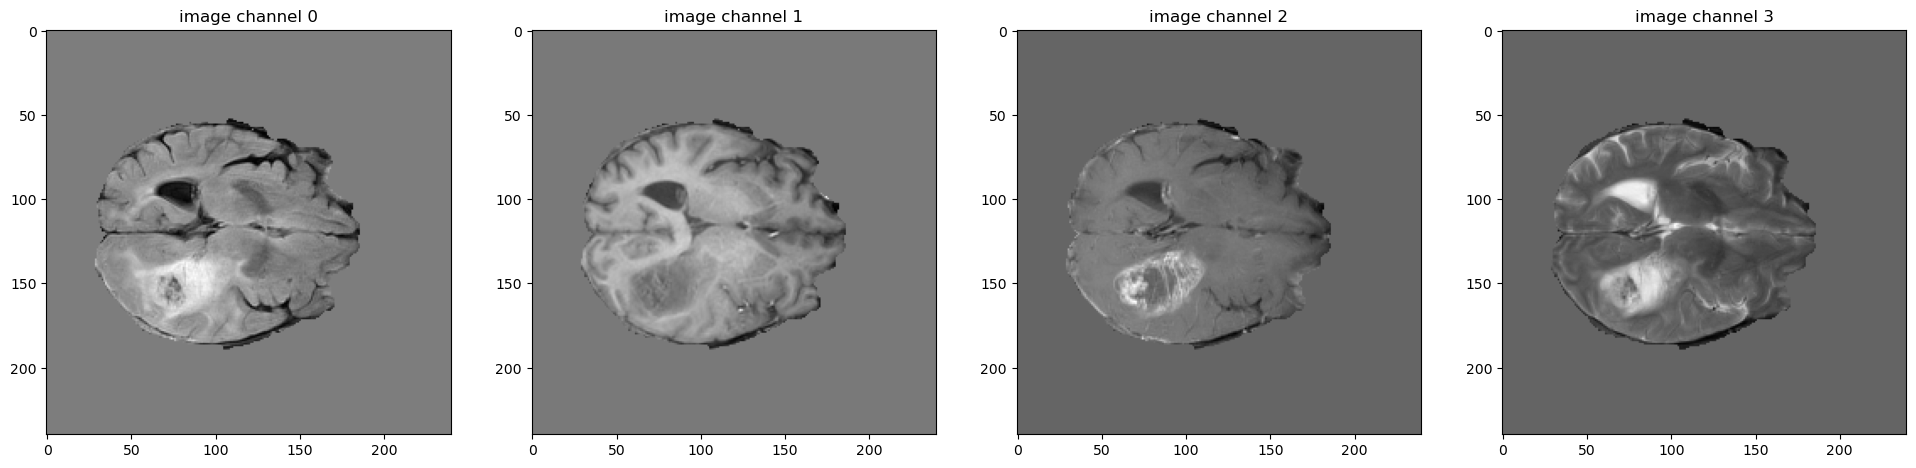

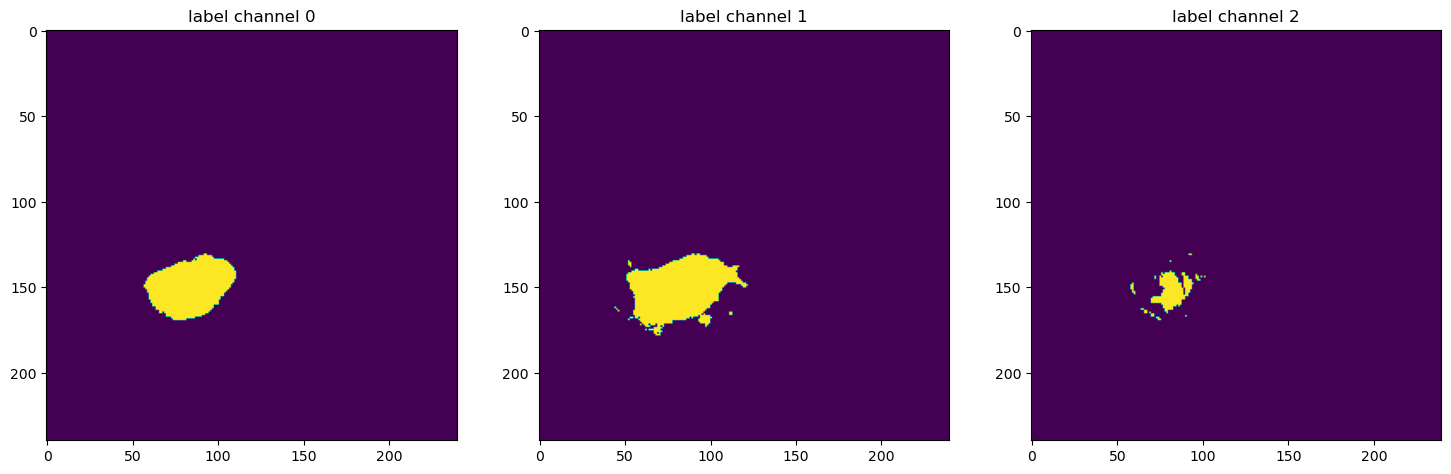

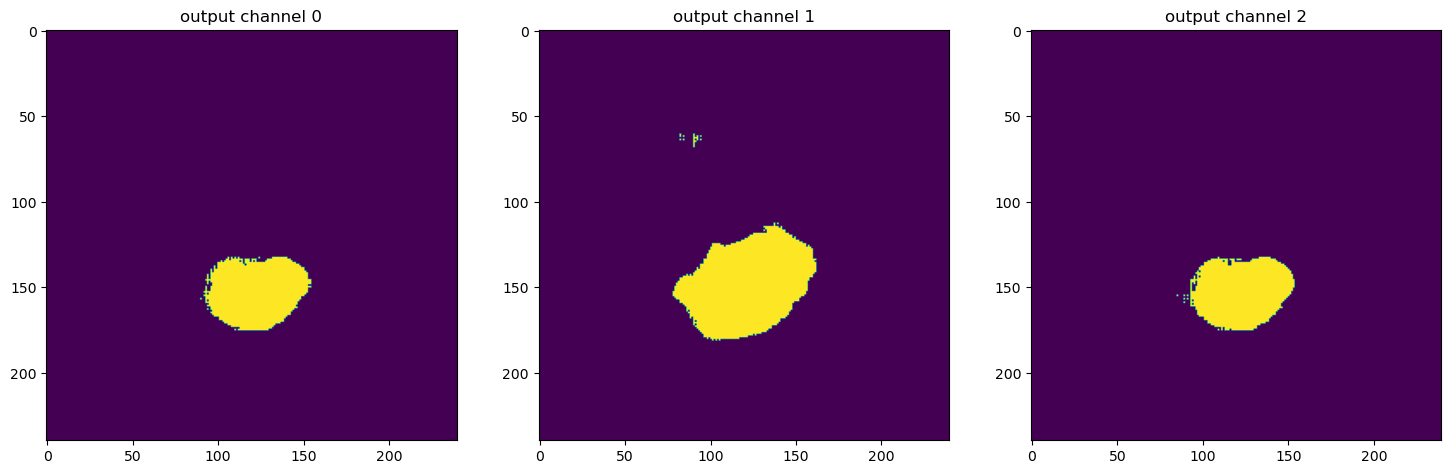

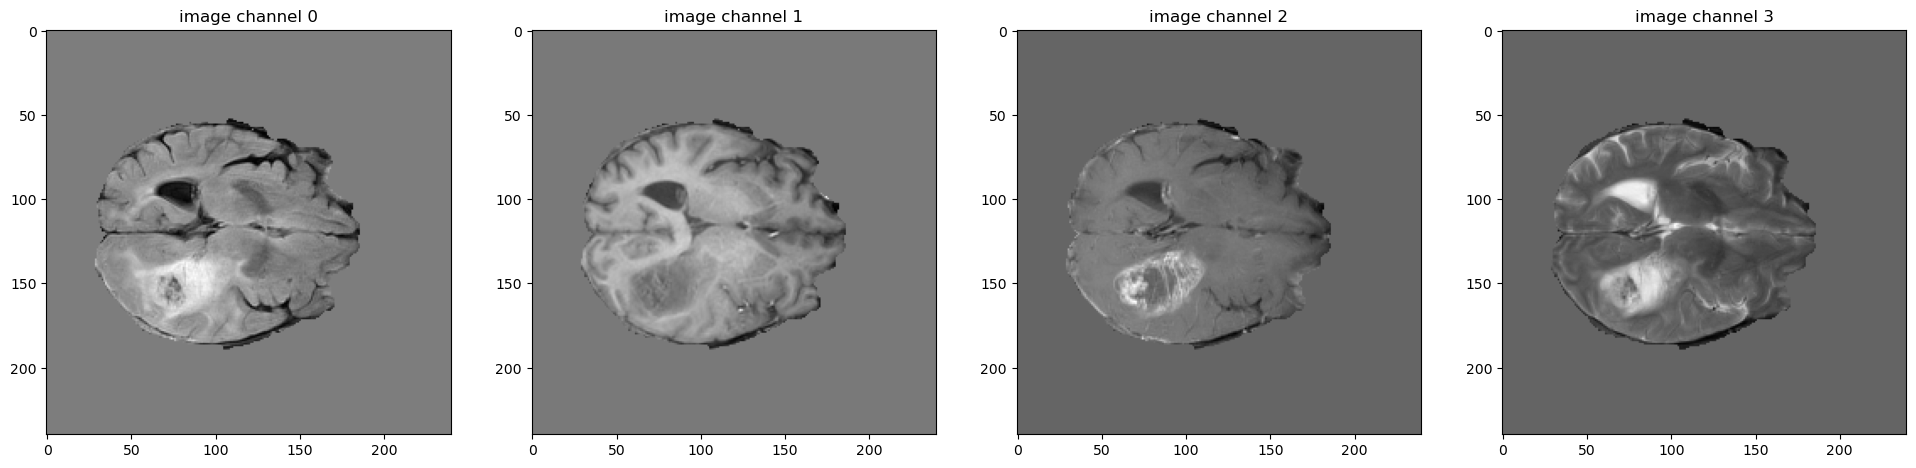

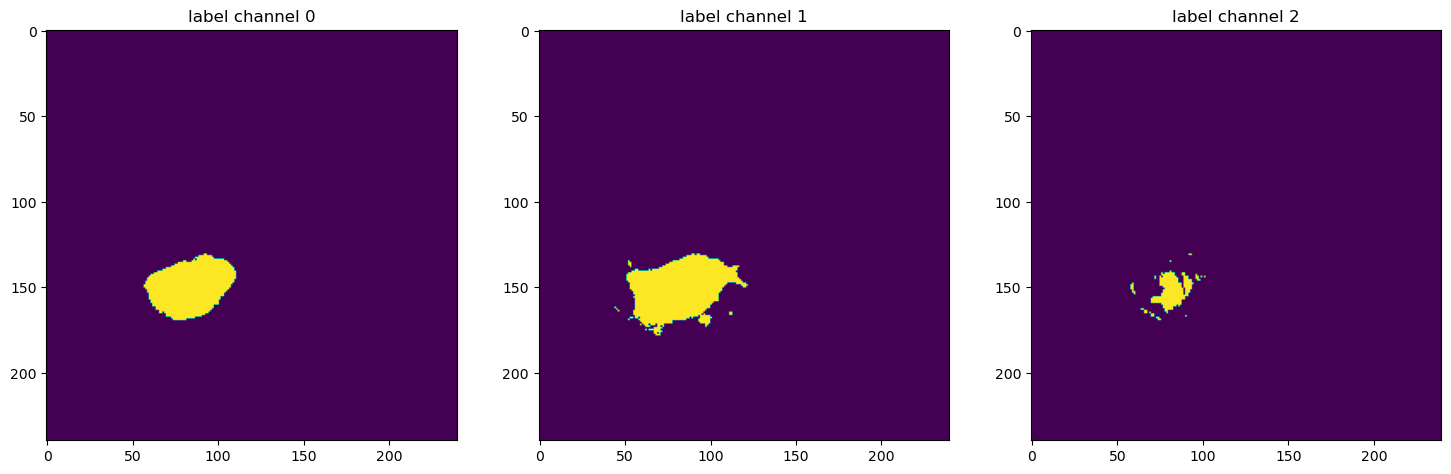

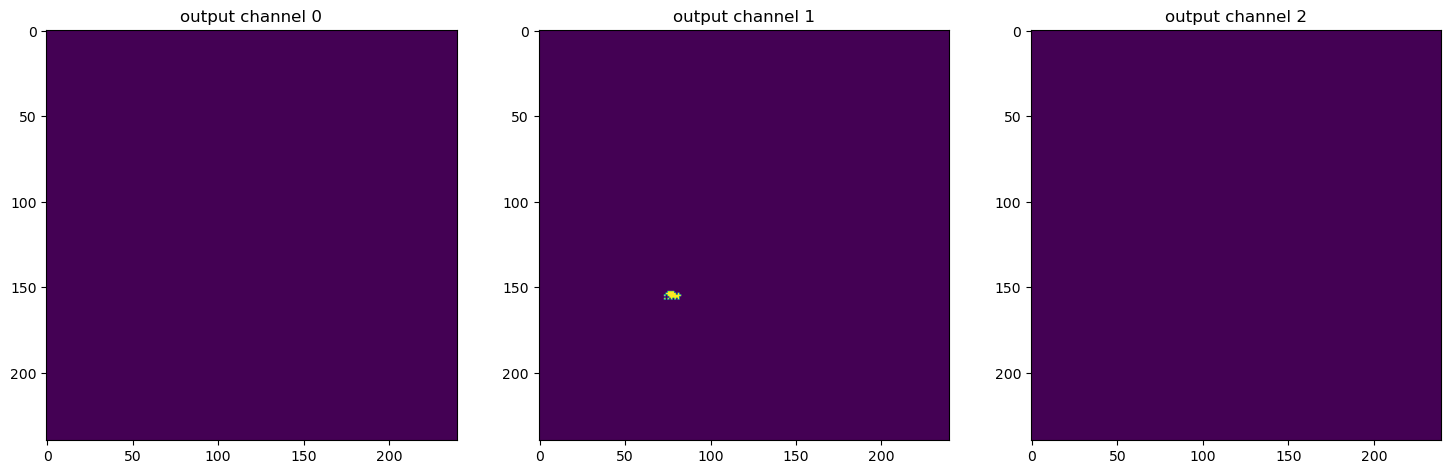

In [13]:
#visualize more images:

for im_idx in range(1, 20, 2):
    val_input = val_ds[im_idx]["image"].unsqueeze(0)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[6]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()
        
    # visualize the 3 labels
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_ds[6]["label"][i, :, :, 70].detach().cpu())
    plt.show()
        
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 70].detach().cpu())
    plt.show()

With regards to under-prediction or over-prediction, we cannot see a clear trend with just our observations on 10 images. From a purely visual standpoint, it looks like there is still much improvement to be had. We will have to rely on our DICE metric to give us a better indication of how the model is performing. 

## Plot loss metrics

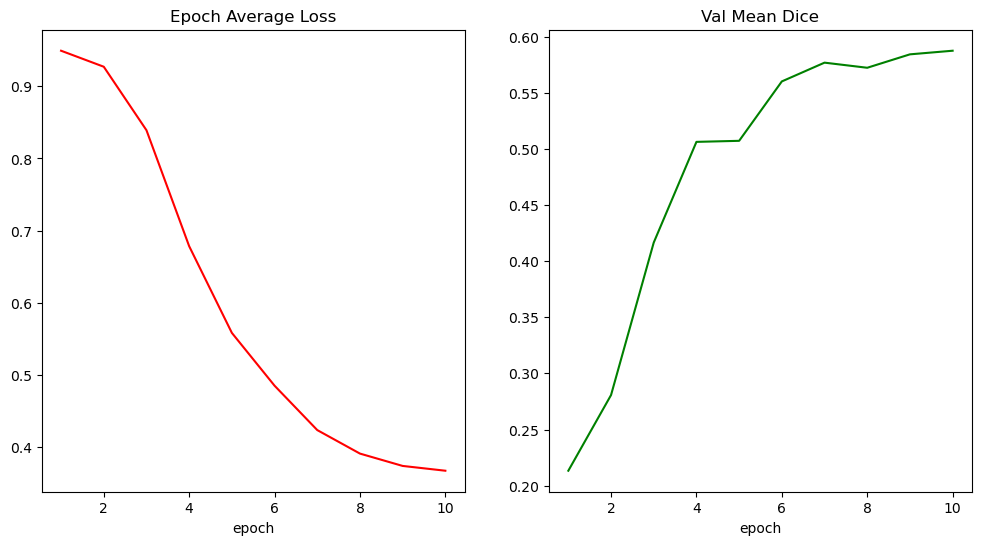

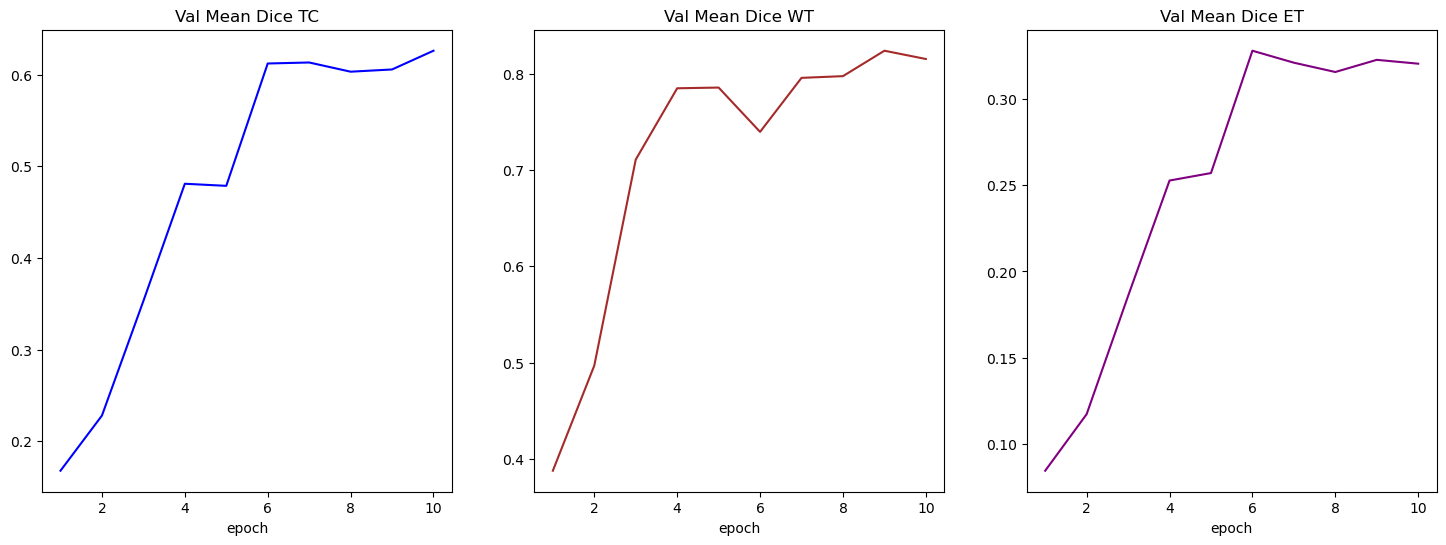

In [14]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()


Within the limited amount of epochs, the Dice values and average loss per epoch show promising results. We see the average loss drop and the slope values begin to approach convergence. Within the mean dice and the dice values for each type of tumor (TC (Tumor core), WT (Whole tumor), and ET (Enhancing tumor) are all increased from epoch 1 to epoch 10. We can imagine that with more training we will be able to further minimze the loss and increase the mean dice value. 



## Evaluate on image dataset

In [22]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image"]),
        BratsToMultiChannel(keys="label"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

val_org_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_org_transforms,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=0,
)
val_org_loader = DataLoader(val_org_ds, batch_size=1, shuffle=False, num_workers=0)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        Activationsd(keys="pred", sigmoid=True),
        AsDiscreted(keys="pred", threshold=0.5),
    ]
)

model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"] #.to(device)
        val_data["pred"] = inference(val_inputs)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        dice_metric(y_pred=val_outputs, y=val_labels)
        dice_metric_batch(y_pred=val_outputs, y=val_labels)

    metric_org = dice_metric.aggregate().item()
    metric_batch_org = dice_metric_batch.aggregate()

    dice_metric.reset()
    dice_metric_batch.reset()

metric_tc, metric_wt, metric_et = metric_batch_org[0].item(), metric_batch_org[1].item(), metric_batch_org[2].item()

In [23]:
print("Metric on original image spacing: ", metric_org)
print(f"metric_tc: {metric_tc:.4f}")
print(f"metric_wt: {metric_wt:.4f}")
print(f"metric_et: {metric_et:.4f}")

Metric on original image spacing:  0.5873537659645081
metric_tc: 0.6263
metric_wt: 0.8151
metric_et: 0.3207


The metric in question here is the Mean Dice Metric, which is based on the Dice Coefficient. The Dice Coefficient measures the pixel-wise agreement between the predicted segmentation image and the ground truth. 
Essentially, this is a measure of how similar the predicted segment is to the actual tumor area. 

As we can see above, even with minimal training, the model predicted best on the whole tumor, followed by the tumor core. Accuracy regarding the enhacing tumor (edema portion) was significantly lower. This is a key area for future prediction as the poor prediction on the enhacing tumor resulted in significantly lower mean dice values and contributed negatively to the mean accuracy. 

